# **Associate Data Scientist Project for CH Robinson**
Produced by: Jamie Boehme

Overview: C.H. Robinson works with customers who need to find carriers to ship goods, and who can drive those goods from an origin location to a destination location. When customers need CH Robinson to perform these services, they request an order. C.H. Robinson, for a variety of reasons,
may decide to reject the order, accept the order, or create another status for the order. For this project, I built three classifiers that will produce predictions on the Current Condition of an order request. This modeling could potentially be used to:
* Inform customers of the predicted Condition of their order just after placement
* Inform CH Robinson of the characteristics of an order that lead to unpleasurable outcomes (Waiting status', Rejection, Withdrawn, Cancelled) 
* Show potential opportunities for request form optimization, route specialization, etc.

## **Data and Notebook Setup**

*Import the libraries that will be needed in order to explore the dataset and train machine learning models.*
* pandas: for creating and manipulating dataframes
* numpy: to support mathematical calculations and exploratory analysis
* matplotlib, matplotlib.pyplot, seaborn, and dython.nominal to support visualizations of the dataset
* varios sklearn models, metrics, and graphing capabilties to run/test classification models

In [1081]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt 
import seaborn as sns
from dython.nominal import associations
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import classification_report
import warnings 
warnings.filterwarnings('ignore')

*Read raw csv data from public Github repository: https://github.com/jamieboehme/CH_Robinson_Project into a new dataframe.*
* Show the first 5 rows for all columns to better understand the type of values shown in this dataset, hosted in a new dataframe (df).

In [1082]:
url = "https://raw.githubusercontent.com/jamieboehme/CH_Robinson_Project/main/IMA%20Recommendation%20Simulation%20Data.csv?token=AO6S3HXJEPALURIGM7GOP5DBMCBYO"
df = pd.read_csv(url,index_col=0)
df_copy = df
df.head()

request_id  week_id weekday  miles  \
0  c2653eda11cd4d94879d1946392eb2b5        4     Sat   1856   
1  65e3dcc84a2246e68ea8636a967b31b2        3     Mon     56   
2  0a86f005640a4204b46c95ca033a7ced        1     Fri    259   
3  1105b4bc7b444f7985d4ad810e7acbc2        3     Thu     71   
4  de538100bb0f4137961b9551640ef35e        3     Fri   1182   

  order_equipment_type  order_distance  order_num_stops  order_origin_weight  \
0                    V          1848.0                2              40000.0   
1                    V            47.0                2              12729.0   
2                    V           255.0                2              44176.0   
3                    V            68.0                2              39847.0   
4                    R          1183.0                2              34912.0   

   lead_days  color  origin_dat_ref  dest_dat_ref  rate_norm  est_cost_norm  \
0          3    RED             633           978   2.273442       2.138631   
1          3    RED             604           604  -0.971030      -1.017024   
2          3    RED             761           770  -0.393352      -0.475805   
3          6    RED             187           180  -0.706546      -0.765855   
4          3  GREEN             972           922   1.014233       0.469273   

  CurrentCondition  
0         Accepted  
1         Rejected  
2         Accepted  
3         Rejected  
4         Accepted

*Determine number of rows and columns in dataset (also referred to as the shape)*
* The shape of the data is 161,563 rows by 15 columns

In [1083]:
df.shape

(161563, 15)

*Determine the count of unique values in CurrentCondition, the variable to predict later in the Machine Learning Model*
* There are seven unique values of Current Condition, with Accepted being the most used Current Condition.

In [1084]:
df.groupby("CurrentCondition")["CurrentCondition"].count()

CurrentCondition
Accepted                     96165
Cancelled                     3388
NoPace                          54
Rejected                     37143
Waiting On Acceptance          800
Waiting On Recommendation       95
Withdrawn                    23800
Name: CurrentCondition, dtype: int64

## **Exploratory Analysis**

*Determine data types and exploratory information across the dataset, which may influence how to handle certain variables*

In [1085]:
df.dtypes

request_id               object
week_id                   int64
weekday                  object
miles                     int64
order_equipment_type     object
order_distance          float64
order_num_stops           int64
order_origin_weight     float64
lead_days                 int64
color                    object
origin_dat_ref            int64
dest_dat_ref              int64
rate_norm               float64
est_cost_norm           float64
CurrentCondition         object
dtype: object

In [1086]:
df.describe()

week_id          miles  order_distance  order_num_stops  \
count  161563.000000  161563.000000   156885.000000    161563.000000   
mean        2.440559     624.808490      604.038876         2.030781   
std         1.125998     563.541693      555.309102         0.198188   
min         1.000000       1.000000        0.000000         2.000000   
25%         1.000000     236.000000      225.000000         2.000000   
50%         2.000000     450.000000      433.000000         2.000000   
75%         3.000000     820.000000      795.000000         2.000000   
max         4.000000    6171.000000     3274.000000         4.000000   

       order_origin_weight      lead_days  origin_dat_ref   dest_dat_ref  \
count         1.615440e+05  161563.000000   161563.000000  161563.000000   
mean          3.478955e+04       5.302885      502.882343     528.266973   
std           5.731309e+04       5.861072      256.895274     266.437711   
min           1.000000e+00    -363.000000       10.000000      10.000000   
25%           2.615200e+04       2.000000      303.000000     308.000000   
50%           4.090000e+04       4.000000      462.000000     490.000000   
75%           4.350400e+04       7.000000      734.000000     765.000000   
max           2.123052e+07     365.000000      993.000000     994.000000   

           rate_norm  est_cost_norm  
count  161382.000000  161524.000000  
mean       -0.000004      -0.000002  
std         0.997790       0.997738  
min        -4.380299      -3.796739  
25%        -0.667874      -0.700136  
50%        -0.248811      -0.268423  
75%         0.440396       0.494081  
max        31.589768      11.162772

In [1087]:
df.describe(include =object)

request_id weekday order_equipment_type   color  \
count                             161563  161563               161563  161563   
unique                            161562       7                    2       3   
top     f0293ccd87b445f5989c6c68726608dc     Thu                    V     RED   
freq                                   2   33734               149690   94557   

       CurrentCondition  
count            161445  
unique                7  
top            Accepted  
freq              96165

*Determine if request_id is completely unique.* 
* There are two records in our dataset that show the same request_id, making it appear as though there is a duplicate in request_id. Below are the two records and their associate record id. For this purpose I will drop the second record while training my machine learning model

In [1088]:
df[df.duplicated(["request_id"], keep=False)]

request_id  week_id weekday  miles  \
81223  f0293ccd87b445f5989c6c68726608dc        3     Fri    147   
81224  f0293ccd87b445f5989c6c68726608dc        3     Fri    147   

      order_equipment_type  order_distance  order_num_stops  \
81223                    V           151.0                2   
81224                    V           151.0                2   

       order_origin_weight  lead_days color  origin_dat_ref  dest_dat_ref  \
81223              45007.0          3   RED             983           972   
81224              45007.0          3   RED             983           972   

       rate_norm  est_cost_norm CurrentCondition  
81223  -0.621826      -0.353353        Withdrawn  
81224  -0.621826      -0.353353        Withdrawn

*Determine if there are any null values in the dataset*
* I found there are some null values in order_distance, order_origin_weight, rate_norm, est_cost_norm, and CurrentCondition. However, the null values represent a very small percentage of the overall dataset. I may choose to later drop the Null values, or impute the values with something more meaningful such as the mean.

In [1089]:
df.isnull().values.any()

True

In [1090]:
df.isnull().sum()

request_id                 0
week_id                    0
weekday                    0
miles                      0
order_equipment_type       0
order_distance          4678
order_num_stops            0
order_origin_weight       19
lead_days                  0
color                      0
origin_dat_ref             0
dest_dat_ref               0
rate_norm                181
est_cost_norm             39
CurrentCondition         118
dtype: int64

In [1091]:
df.isnull().sum() * 100 / len(df)

request_id              0.000000
week_id                 0.000000
weekday                 0.000000
miles                   0.000000
order_equipment_type    0.000000
order_distance          2.895465
order_num_stops         0.000000
order_origin_weight     0.011760
lead_days               0.000000
color                   0.000000
origin_dat_ref          0.000000
dest_dat_ref            0.000000
rate_norm               0.112031
est_cost_norm           0.024139
CurrentCondition        0.073037
dtype: float64

*Determine the features most highly correlated across the dataset.*
* I computed Pearson's correlation across numerical variables using the Seaborn library, and show the values of each correlation in the graph. 
* I then computed the correlation across all variables, again using Pearson's correlation for numerical variables and Cramer's method for categorical variables, dropping variables that had null values.

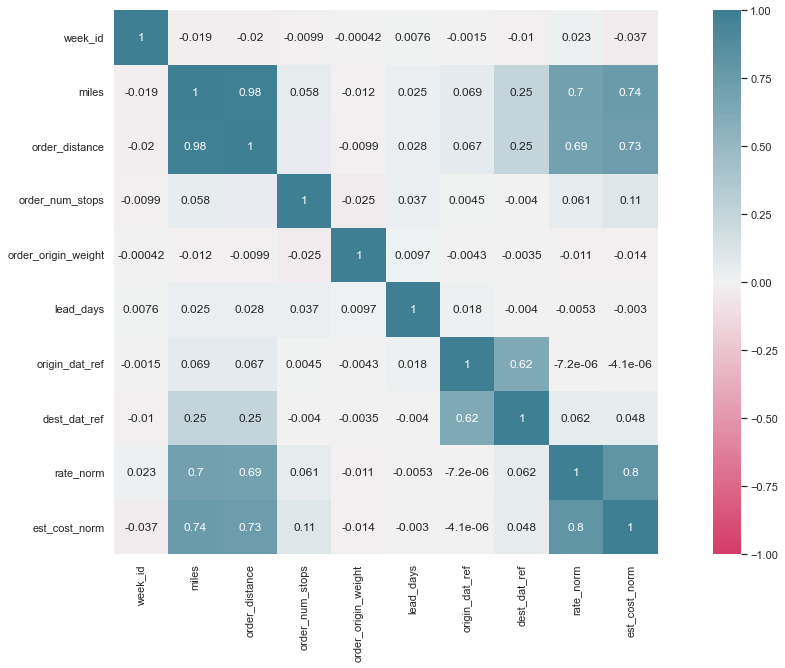

In [1092]:
sns.set(rc = {'figure.figsize':(20,10)})
graph = sns.heatmap (
    corr,
    vmin = -1, vmax = 1, center =0,
    cmap=sns.diverging_palette(0, 220, n = 220),
    square = True,
    annot = True
);

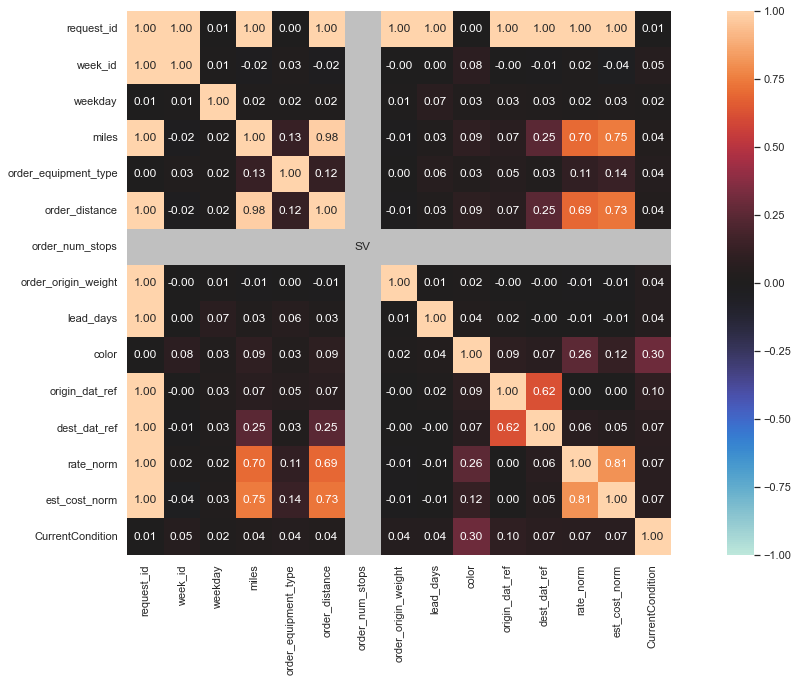

{'corr':                       request_id   week_id   weekday     miles  \
 request_id              1.000000  1.000000  0.006190  1.000000   
 week_id                 1.000000  1.000000  0.013144 -0.018698   
 weekday                 0.006190  0.013144  1.000000  0.019640   
 miles                   1.000000 -0.018698  0.019640  1.000000   
 order_equipment_type    0.002527  0.028470  0.016674  0.127223   
 order_distance          1.000000 -0.019778  0.021728  0.982270   
 order_num_stops         0.000000  0.000000  0.000000  0.000000   
 order_origin_weight     1.000000 -0.001049  0.007906 -0.010400   
 lead_days               1.000000  0.004335  0.073004  0.025702   
 color                   0.003574  0.079465  0.025626  0.093965   
 origin_dat_ref          1.000000 -0.001141  0.033847  0.069836   
 dest_dat_ref            1.000000 -0.010404  0.027219  0.249615   
 rate_norm               1.000000  0.023086  0.019373  0.701192   
 est_cost_norm           1.000000 -0.038480  0.027260 

In [1093]:
associations(df, nan_strategy = 'drop_samples', figsize=(20,10))

*Correlation Analysis*

The following pairs of data attributes appear to be most correlated:
1. miles and order_distance
2. rate_norm and est_cost_norm

The values most correlated make intuitive sense. Number of miles on a route and order_distance logically should be very similar, where order_distance represents the direct path from origin to destination and assumingly miles represents the path a carrier can take to deliver goods from the origin to the destination. I would expect miles to be very mildly greater than order_distance to account for this.

Similarly, I think it is plausible to assume est_cost_norm is directly influenced by the rate_norm in its calculation. Therefore, these two variables make sense to also be correlated.

### Additional exploratory analysis

I like to explore the data more using bar plots, histograms, box plots, and cross tabs in order to better understand if any of the variables are skewed or appear to influence the Current Condition. In order to do this, I will first define how to build different graphs, and then loop over the graphs dependent upon the type of variable.

*Define and plot categorical variables*

Findings:
* Shipping rarely happens on weekend, but is fairly spread throughout the Monday-Friday.
* Generally 'V' is being requested at the order_equipment_type
* Red vehicles are most prevalent in CH Robinson's shipping
* weekday and color appear to have no apparent influence on CurrentCondition, where as color is showing some influence with 'red' colored shipping methods appear to be rejected more often than other colors.

In [1094]:
colors = ['mediumturquoise', 'blueviolet', 'mediumvioletred', 'palegreen']
small_size= 12
mp.rc('font', size=small_size)
mp.rc('axes', titlesize=small_size)

def graph_cat(variable_cat_or_ord):
    values = df[variable_cat_or_ord].value_counts(normalize=True)
    percent = values * 100
    return percent.plot.bar(title = variable_cat_or_ord, ylim=(0,100))

def cross_graph(tabular_num):
    var = pd.crosstab(df[tabular_num], df['CurrentCondition'])
    graph = var.div(var.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, title = '{} vs Current Condition'.format(tabular_num))
    return graph

graph_cat_variables = ['weekday', 'order_equipment_type', 'color']

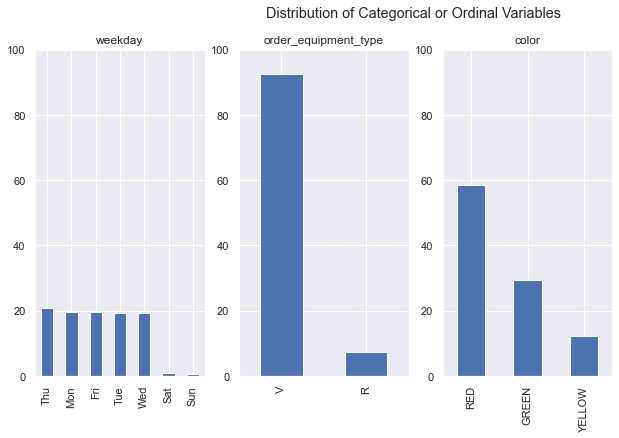

In [1095]:
fig1 = plt.figure(figsize=(14,6))
plt.suptitle('Distribution of Categorical or Ordinal Variables')

plotnum=1
for cat_var in graph_cat_variables:
    plt.subplot(1,4,plotnum)
    graph_cat(cat_var)
    plotnum +=1
plt.show()

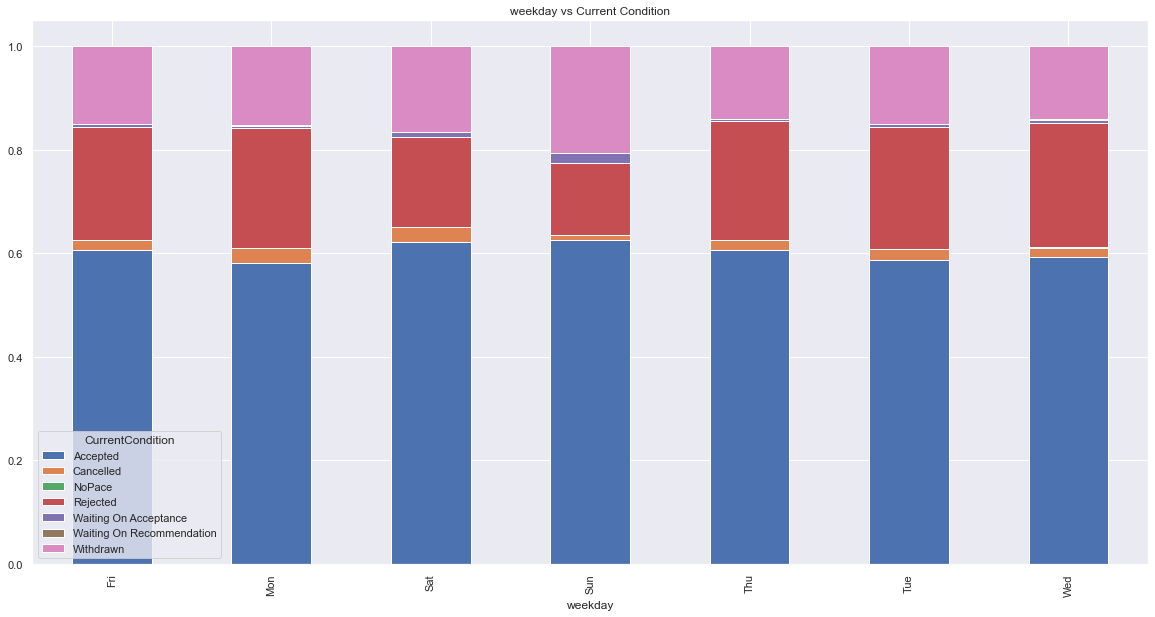

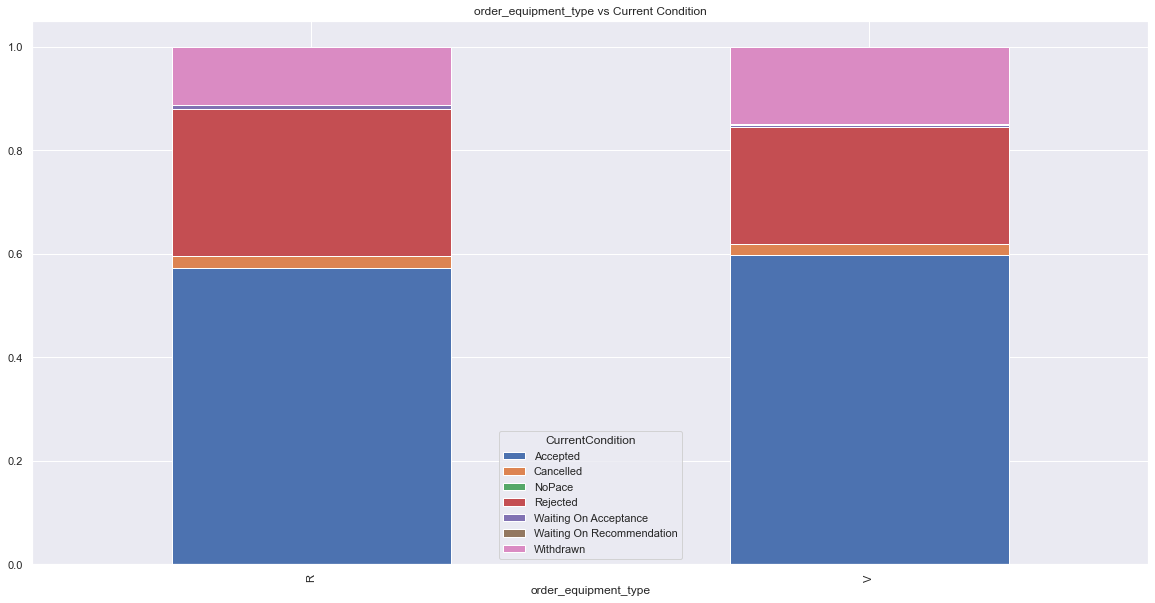

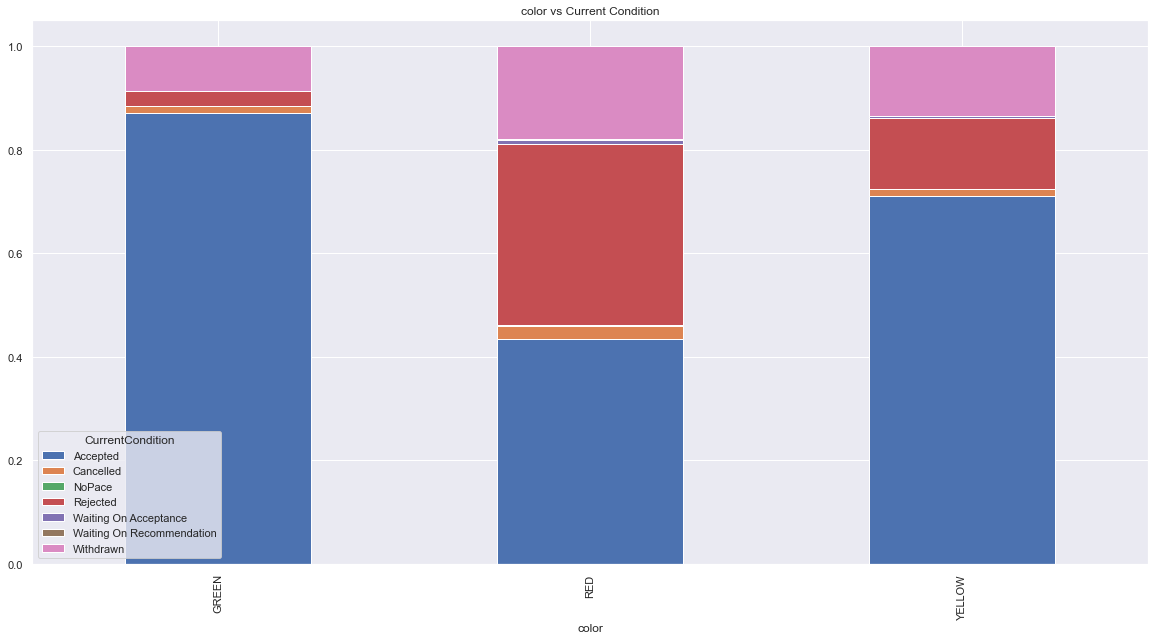

In [1096]:
for cat_and_target in graph_cat_variables:
    cross_graph(cat_and_target)
plt.show()

*Define and plot numerical variables*


In [1097]:
def graph_num(num_variable):
    sns.histplot(df[num_variable])
    
def graph_boxplot(num_variable):
    df[num_variable].plot.box()
    
graph_numeric_var = ['miles', 'order_distance', 'order_num_stops', 'order_origin_weight'] 
graph_numeric_var2 = ['lead_days','rate_norm','est_cost_norm','origin_dat_ref','dest_dat_ref']

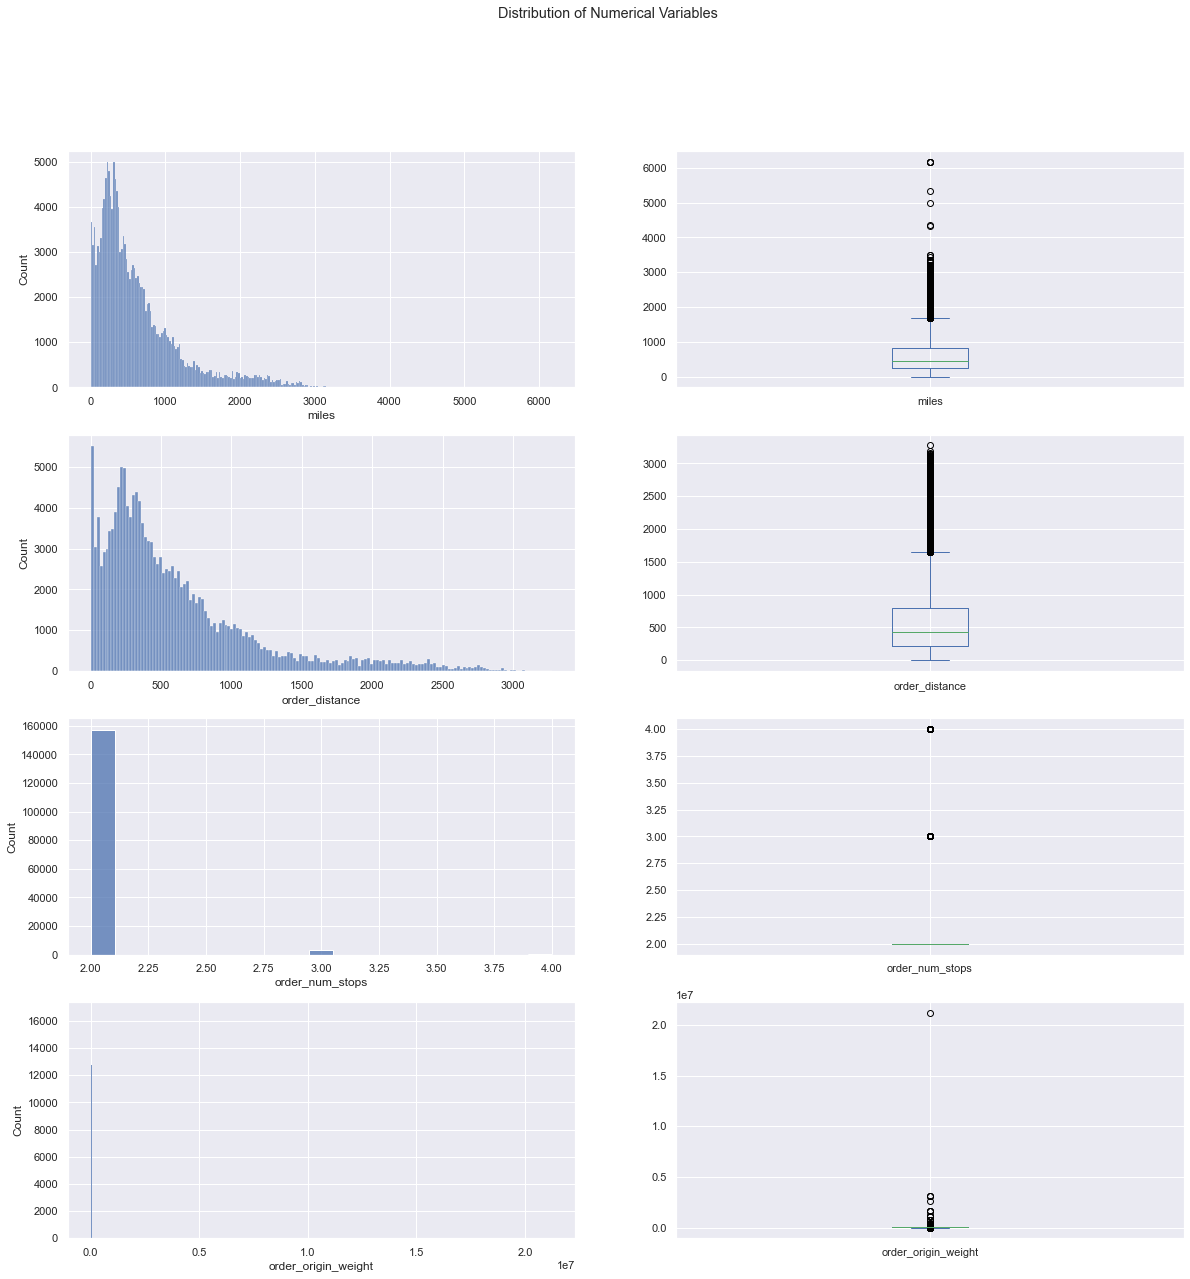

In [1098]:
plot_num = plt.figure(figsize=(20,20))
plt.suptitle('Distribution of Numerical Variables')

plotnum=1
for num_var in graph_numeric_var:
    plt.subplot(4,2,plotnum)
    graph_num(num_var)
    plotnum +=1
    plt.subplot(4,2,plotnum)
    graph_boxplot(num_var)
    plotnum +=1
plt.show()

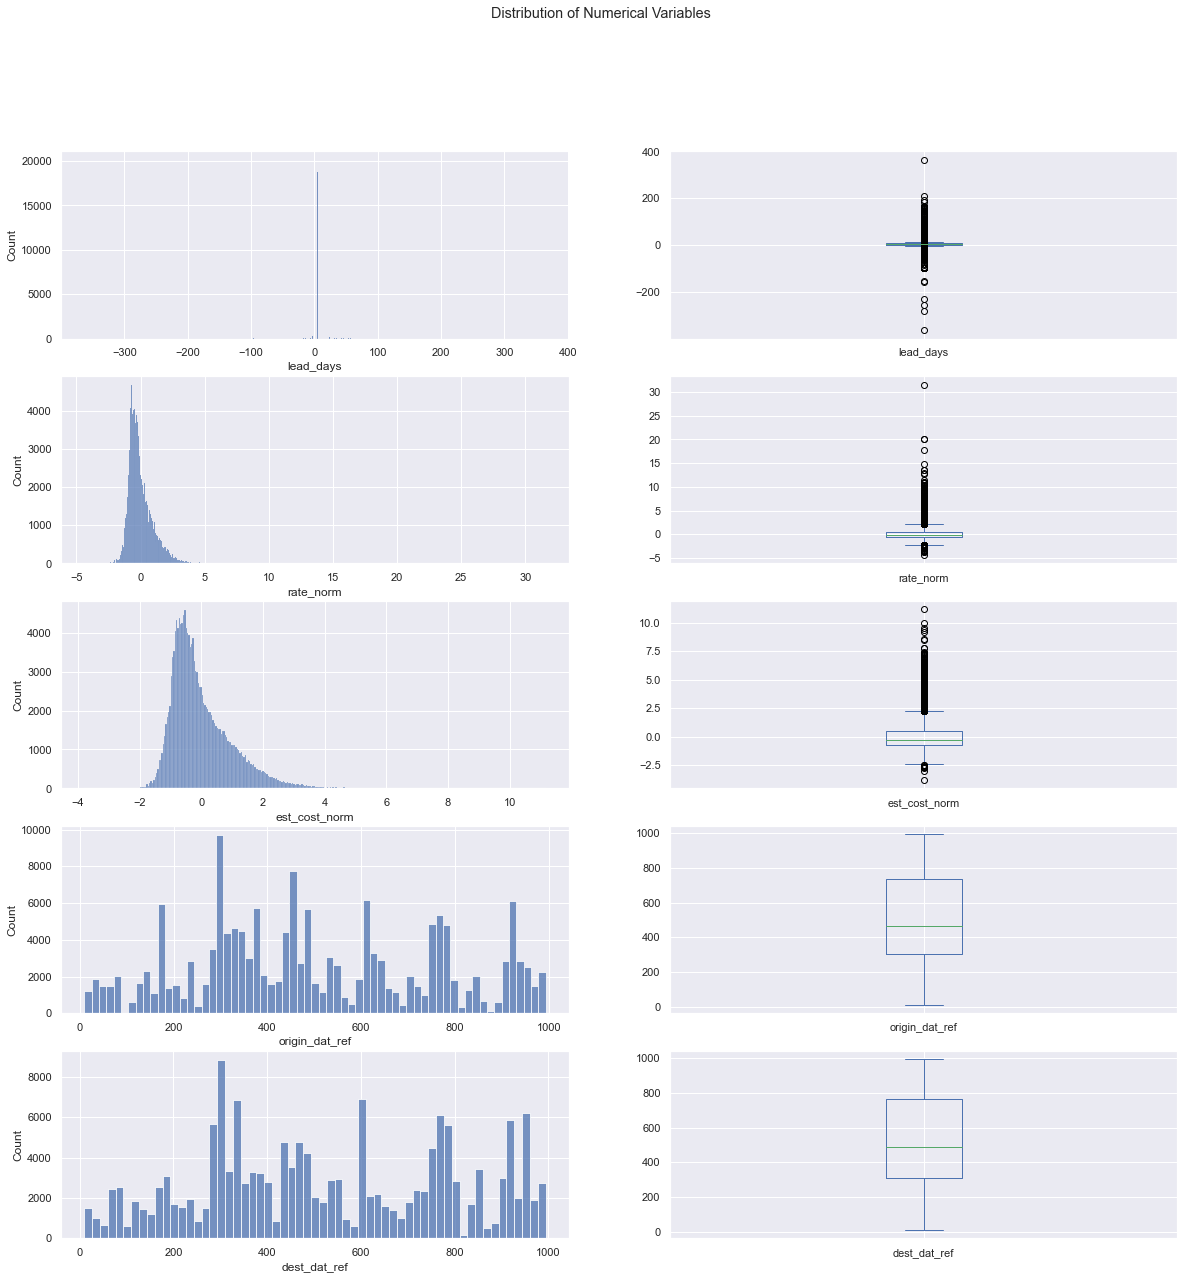

In [1099]:
plot_num2 = plt.figure(figsize=(20,20))
plt.suptitle('Distribution of Numerical Variables')

plotnum=1
for num_var2 in graph_numeric_var2:
    plt.subplot(5,2,plotnum)
    graph_num(num_var2)
    plotnum +=1
    plt.subplot(5,2,plotnum)
    graph_boxplot(num_var2)
    plotnum +=1
plt.show()

Findings:
* Miles, order_distance, rate_norm, and est_cost_norm all have skewed distribution, that I may want to normalize prior to modeling as to not overfit the data.
* There are typically two stops for every shipping order, but can be up to four
* There is a sizable outlier in the order_origin_weight attribute, that I will want to remove prior to modeling as to not skew my prediction and again overfit the data

*Evaluate if some of the numeric variables appear to have an influence on Current Condition*

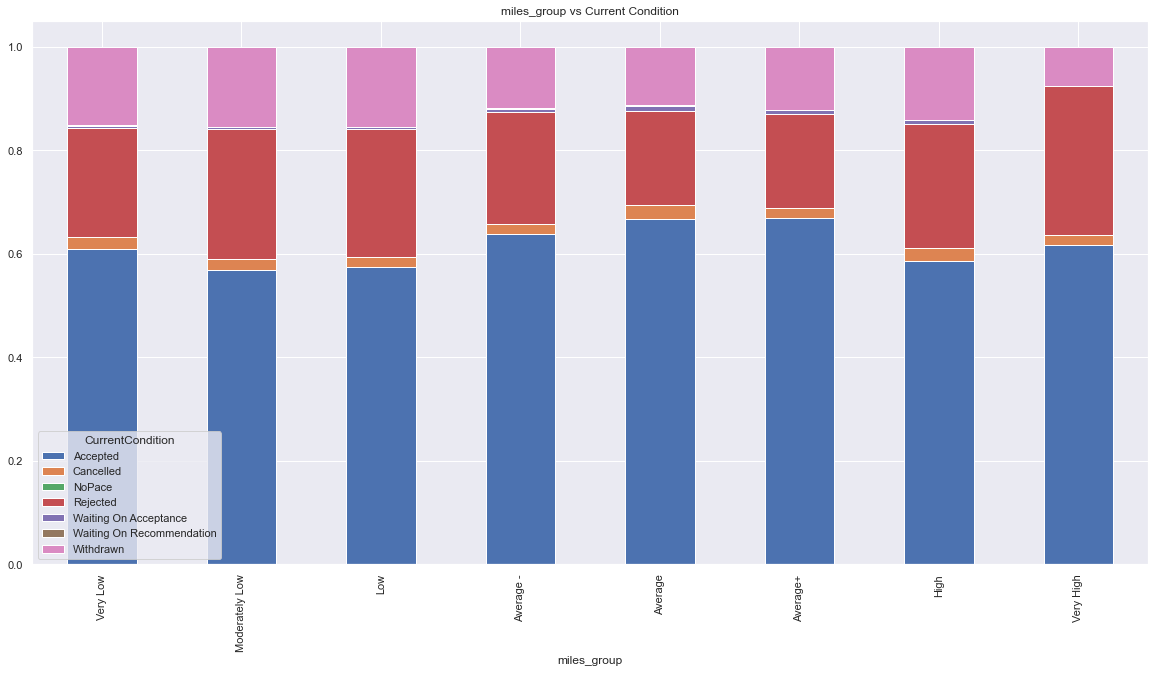

In [1100]:
df_avg_miles = df.groupby(['CurrentCondition'])['miles'].mean()
miles_bins = [0,250,500,1000,1500,2000,2500,3000,3500]                      # create income bins
miles_group = ['Very Low', 'Moderately Low','Low', 'Average -', 'Average', 'Average+','High','Very High']     # develop bin labels
df['miles_group'] = pd.cut(df['miles'], miles_bins, labels=miles_group)
cross_graph('miles_group')
plt.show()

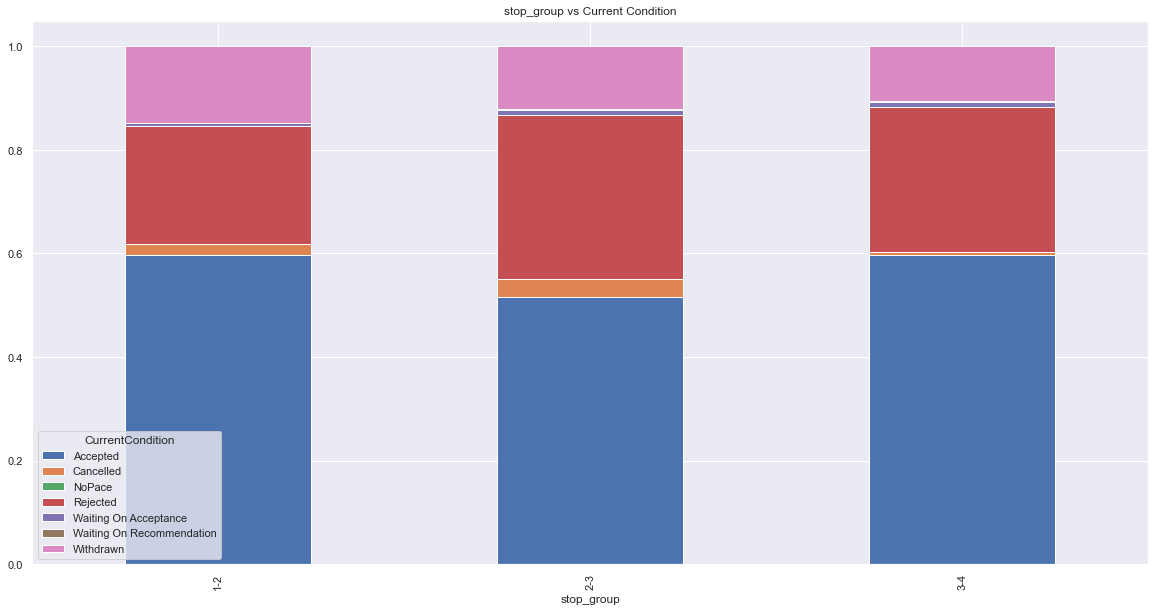

In [1101]:
df_avg_stops = df.groupby(['CurrentCondition'])['order_num_stops'].mean()
stop_bins = [0,1,2,3,4]                      # create income bins
stop_group = ['0-1','1-2','2-3','3-4']     # develop bin labels
df['stop_group'] = pd.cut(df['order_num_stops'], stop_bins, labels=stop_group)
cross_graph('stop_group')
plt.show()

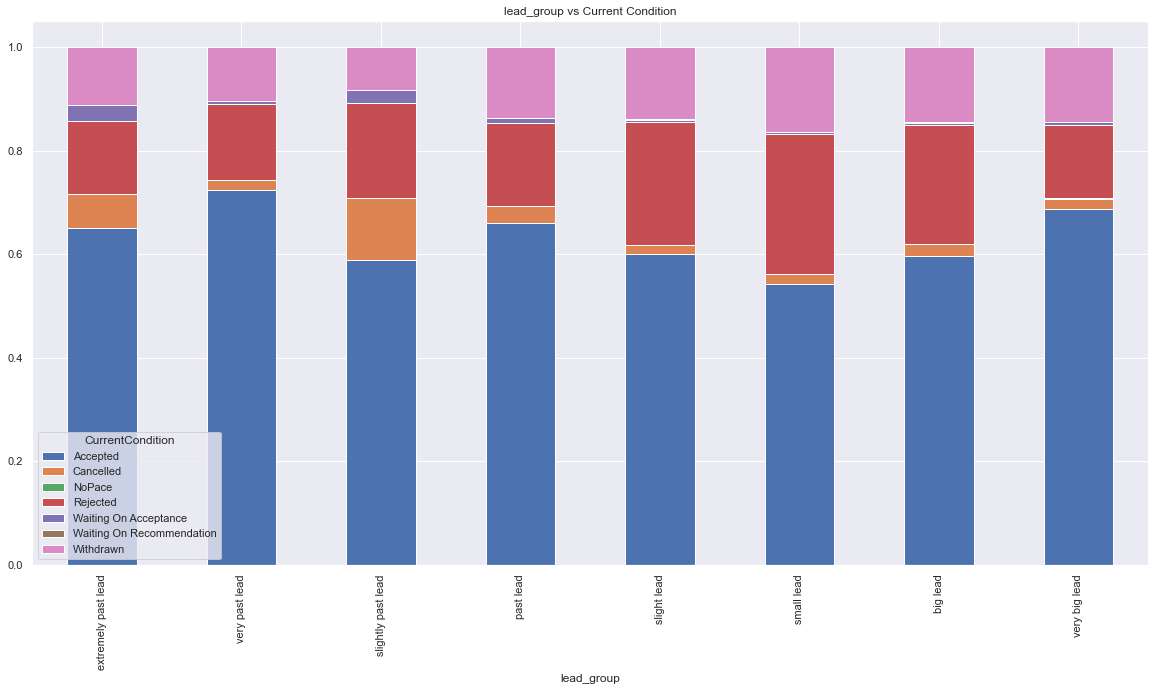

In [1102]:
df_avg_lead = df.groupby(['CurrentCondition'])['lead_days'].mean()
lead_bins = [-100,-10,-5,-3,0,3,5,10,100]                      # create income bins
lead_group = ['extremely past lead','very past lead','slightly past lead','past lead','slight lead','small lead','big lead', 'very big lead']     # develop bin labels
df['lead_group'] = pd.cut(df['lead_days'], lead_bins, labels=lead_group)
cross_graph('lead_group')
plt.show()

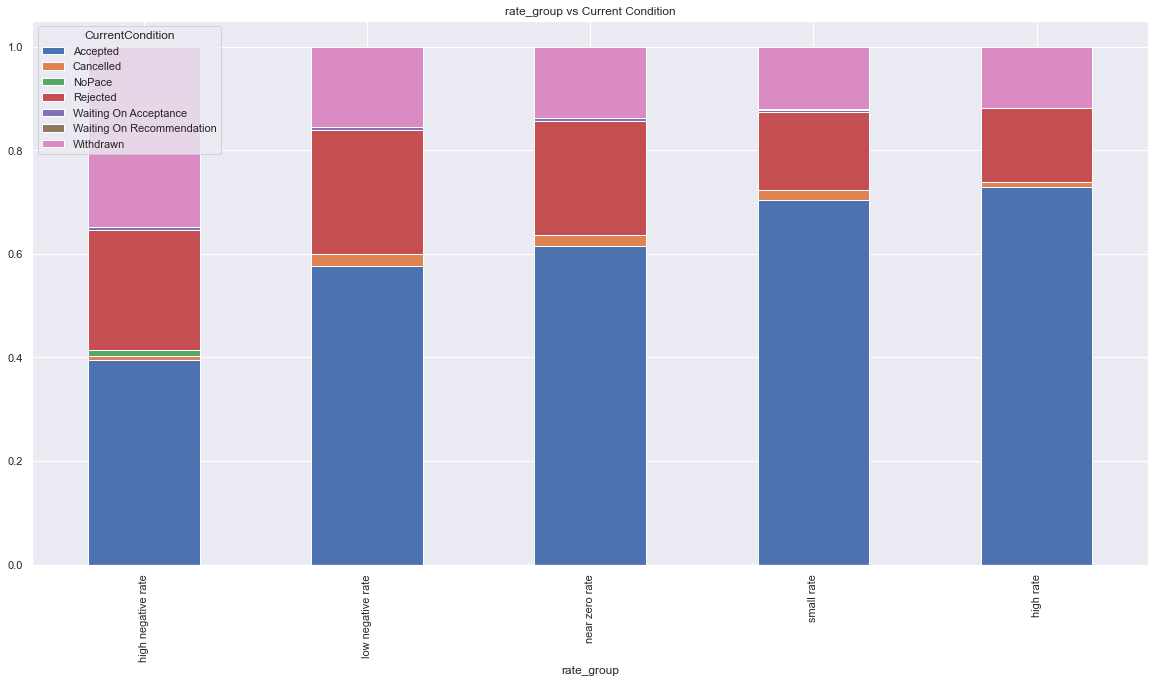

In [1103]:
df_avg_rate = df.groupby(['CurrentCondition'])['rate_norm'].mean()
rate_bins = [-4,-2,0,2,4,5]                      # create income bins
rate_group = ['high negative rate','low negative rate','near zero rate','small rate','high rate']     # develop bin labels
df['rate_group'] = pd.cut(df['rate_norm'], rate_bins, labels=rate_group)
cross_graph('rate_group')
plt.show()

Findings:
* Those shipments reflecting lower miles or very high miles needed to be shipped are most often rejected
* Number of stops appears to have very little affect on the Current condition
* CH Robinson is more likely to accept a request where they are very past the amount of lead days to complete the shipment or have a very big lead time. When there is a smaller lead time not yet passed, they are more likely to reject the request.

### Prep data for modeling

*Given everything I have learned about the dataset, I am going to do the following preparation to ensure I don't overfit my model to predict Current Condition

* Drop any variables that were developed when doing exploratory analysis
* Remove variables that we know will not be used to predict Current Condition: request_id
* Drop any variables that are highly correlated such that the model isn't over-fit. I chose to remove the order_distance column, such that the model isn't over-fitted as well as has no missing values for that piece of data since miles has no missing values. Secondly, I chose to remove rate_norm vs est_cost_norm as again, est_cost_norm has less missing values and can represent that particular data point.
* Drop all records that have Infinite(lead days) and Null values, rather than imputing a mode or mean because with the exception of order_distance, noted above, they represent less than 1% of my total dataset and therefore I don't think they will reveal a valuable contribution to the model.
* Remove outliers and skewness in the data, specifically for the following attributes:miles, order_origin_weight, lead_days, and estimate_cost_norm

In [1104]:
clean_df = df

In [1105]:
clean_df = clean_df.drop(columns=['miles_group','stop_group', 'lead_group', 'rate_group', 'order_distance','rate_norm', 
                                 'request_id'])

In [1106]:
clean_df.head()

week_id weekday  miles order_equipment_type  order_num_stops  \
0        4     Sat   1856                    V                2   
1        3     Mon     56                    V                2   
2        1     Fri    259                    V                2   
3        3     Thu     71                    V                2   
4        3     Fri   1182                    R                2   

   order_origin_weight  lead_days  color  origin_dat_ref  dest_dat_ref  \
0              40000.0          3    RED             633           978   
1              12729.0          3    RED             604           604   
2              44176.0          3    RED             761           770   
3              39847.0          6    RED             187           180   
4              34912.0          3  GREEN             972           922   

   est_cost_norm CurrentCondition  
0       2.138631         Accepted  
1      -1.017024         Rejected  
2      -0.475805         Accepted  
3      -0.765855         Rejected  
4       0.469273         Accepted

In [1107]:
clean_df.dropna(inplace=True)
clean_df.isnull().sum()

week_id                 0
weekday                 0
miles                   0
order_equipment_type    0
order_num_stops         0
order_origin_weight     0
lead_days               0
color                   0
origin_dat_ref          0
dest_dat_ref            0
est_cost_norm           0
CurrentCondition        0
dtype: int64

In [1108]:
clean_df['miles_log'] = np.log(clean_df['miles'])
clean_df['order_origin_log'] = np.log(clean_df['order_origin_weight'])
clean_df['lead_days_log'] = np.log(clean_df['lead_days']- (min(clean_df.lead_days) - 1))
clean_df['est_cost_log'] = np.log(clean_df['est_cost_norm']- (min(clean_df.est_cost_norm) - 1))


*Note, due to lead_days_log and est_cost_log having valid, negative values I executed the log of each value plus the minimum value to ensure there would be no errors present when trying to fit any models*

In [1109]:
clean_df.isnull().sum()

week_id                 0
weekday                 0
miles                   0
order_equipment_type    0
order_num_stops         0
order_origin_weight     0
lead_days               0
color                   0
origin_dat_ref          0
dest_dat_ref            0
est_cost_norm           0
CurrentCondition        0
miles_log               0
order_origin_log        0
lead_days_log           0
est_cost_log            0
dtype: int64

In [1110]:
clean_df.isin([np.inf, -np.inf]).sum()

week_id                 0
weekday                 0
miles                   0
order_equipment_type    0
order_num_stops         0
order_origin_weight     0
lead_days               0
color                   0
origin_dat_ref          0
dest_dat_ref            0
est_cost_norm           0
CurrentCondition        0
miles_log               0
order_origin_log        0
lead_days_log           0
est_cost_log            0
dtype: int64

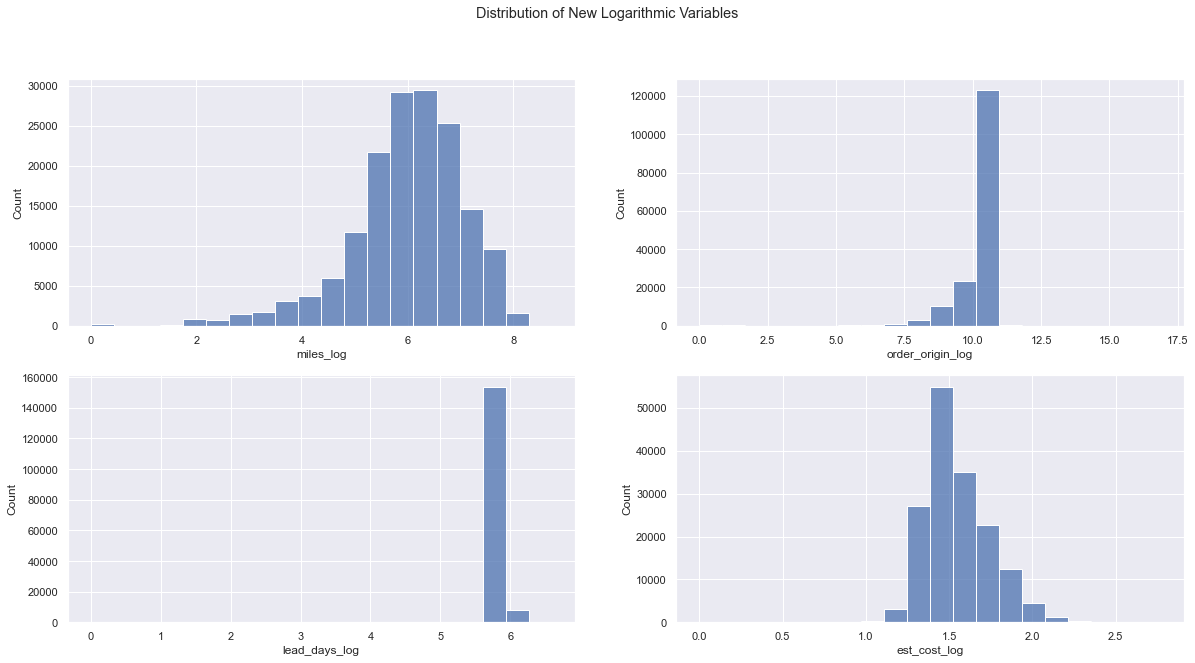

In [1111]:
log_fig = plt.figure(figsize=(20,10))
plt.suptitle('Distribution of New Logarithmic Variables')

plt.subplot(2,2,1)
sns.histplot(clean_df['miles_log'],bins =20)
plt.subplot(2,2,2)
sns.histplot(clean_df['order_origin_log'], bins =20)
plt.subplot(2,2,3)
sns.histplot(clean_df['lead_days_log'], bins =20)
plt.subplot(2,2,4)
sns.histplot(clean_df['est_cost_log'], bins =20)
plt.show()

## Classification Modeling
### Create Test and Train Datasets

*Create train and test datasets to learn and test data models*

In [1112]:
new_df = clean_df.drop(columns=['miles','order_origin_weight','lead_days','est_cost_norm'],axis=1)
new_df_copy = new_df

*Create dummy variables for cateogrical variables, such that we can better use them in our models*

In [1113]:
weekday = pd.get_dummies(train_ds['weekday'], drop_first = True)
order_equipment_type = pd.get_dummies(train_ds['order_equipment_type'], drop_first = True)
color = pd.get_dummies(train_ds['color'], drop_first = True)

*Drop categorical variables that have been replaced with numerical values*

In [1114]:
num_df = new_df.drop(['weekday','order_equipment_type','color'], axis = 1)

*Join the new, cleaned up, dataframe with the new numerical variables*

In [1115]:
new_df = pd.concat([num_df,weekday, order_equipment_type, color],axis=1)

In [1116]:
new_df

week_id  order_num_stops  origin_dat_ref  dest_dat_ref  \
0             4                2             633           978   
1             3                2             604           604   
2             1                2             761           770   
3             3                2             187           180   
4             3                2             972           922   
...         ...              ...             ...           ...   
161558        4                2             170           119   
161559        4                2              57           132   
161560        4                2             551           527   
161561        4                2             490           945   
161562        3                2             378           283   

       CurrentCondition  miles_log  order_origin_log  lead_days_log  \
0              Accepted   7.526179         10.596635       5.905362   
1              Rejected   4.025352          9.451638       5.905362   
2              Accepted   5.556828         10.695937       5.905362   
3              Rejected   4.262680         10.592802       5.913503   
4              Accepted   7.074963         10.460586       5.905362   
...                 ...        ...               ...            ...   
161558         Accepted   5.613128         10.693852       5.899897   
161559         Rejected   5.361292         10.680516       5.916202   
161560         Accepted   5.703782         10.680516       5.905362   
161561         Accepted   7.700295          9.021598       5.929589   
161562         Rejected   6.035481         10.709896       5.908083   

        est_cost_log  Mon  Sat  Sun  Thu  Tue  Wed  V  RED  YELLOW  
0           1.936634    0    1    0    0    0    0  1    1       0  
1           1.329649    1    0    0    0    0    0  1    1       0  
2           1.463472    0    0    0    0    0    0  1    1       0  
3           1.393986    0    0    0    1    0    0  1    1       0  
4           1.661273    0    0    0    0    0    0  0    0       0  
...              ...  ...  ...  ...  ...  ...  ... ..  ...     ...  
161558      1.558307    0    0    0    1    0    0  1    0       0  
161559      1.520240    0    0    0    0    1    0  1    0       1  
161560      1.420232    0    0    0    0    1    0  1    0       0  
161561      1.844799    0    0    0    0    0    1  1    0       0  
161562      1.560778    1    0    0    0    0    0  1    1       0  

[161387 rows x 18 columns]

*Finally, create test and train datasets*

In [1117]:
x_train, x_test, y_train, y_test = train_test_split(new_df.drop('CurrentCondition',axis = 1),
                                                    new_df['CurrentCondition'], test_size = .3)

### First Model: Logistic Regression 

*Fit a logistic regression model based upon default regression classifier*

In [1118]:
logmodel = LogisticRegression(max_iter=500)
logmodel.fit(x_train, y_train)
log_odds = logmodel.coef_[0]
log_predict = logmodel.predict(x_test)

*Evaluate the accuracy of the logistic regression model*

In [1119]:
score = logmodel.score(x_test, y_test)
print(score)

0.5982402875023236


*Alternatively, since convergence isn't being met - I can test the accuracy of this model via cross validation where the the training set is split into k smaller sets and is validated on the remaining part of the data. This is helpful due to the dataset being small*

In [1120]:
cv_score = cross_val_score(LogisticRegression(), 
                            x_train, y_train,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
cv_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.2s finished


array([0.59476326, 0.59476326, 0.59477905])

*Determine the coefficients/value of each of the data attributes in the model*

In [1121]:
pd.DataFrame(log_odds, 
             x_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

coef
lead_days_log     0.388846
YELLOW            0.116674
week_id           0.114397
order_num_stops   0.113865
miles_log         0.088590
V                 0.081682
order_origin_log  0.067051
Thu               0.033345
est_cost_log      0.021473
Wed               0.010461
Sun               0.002939
Sat               0.002620
origin_dat_ref    0.001692
dest_dat_ref      0.000959
Tue              -0.000044
Mon              -0.019511
RED              -0.919374

*Review confusion matrix and classification report for precision(True Positives found vs Actual Results) and recall (True Positives vs Predicted Results)*

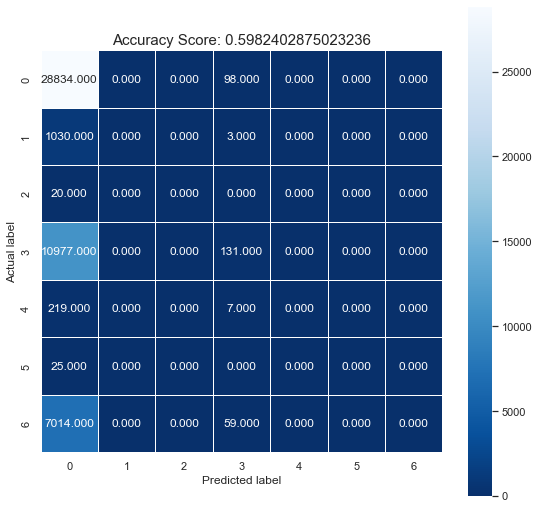

In [1122]:
cm = metrics.confusion_matrix(y_test, log_predict)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [1123]:
print(classification_report(y_test, log_predict))

                           precision    recall  f1-score   support

                 Accepted       0.60      1.00      0.75     28932
                Cancelled       0.00      0.00      0.00      1033
                   NoPace       0.00      0.00      0.00        20
                 Rejected       0.44      0.01      0.02     11108
    Waiting On Acceptance       0.00      0.00      0.00       226
Waiting On Recommendation       0.00      0.00      0.00        25
                Withdrawn       0.00      0.00      0.00      7073

                 accuracy                           0.60     48417
                macro avg       0.15      0.14      0.11     48417
             weighted avg       0.46      0.60      0.45     48417



*Findings of logistic regression model*

* My logistic regression model is about 60% accurate and has the greatest accuracy with predicting 'Accepted' Current Conditions - as that makes up the largest portion of the dataset
* Overall, it appears logistic regression is not a great model for predicting Current Condition, as no other CurrentConditions have a reason precision, recall, and f1-score to trust that it would accurately predict the right CurrentCondition
* The most important features in this model appear to be: lead_days, red color, week_id, and order_num_stops

### Second Model: Decision Tree Classifier

*Fit a decision tree classifier model built on default classifier and evaluate its accuracy*

In [1124]:
tree_model = DecisionTreeClassifier()
tree_model = tree_model.fit(x_train, y_train)
tree_predict = tree_model.predict(x_test)
cv_score = cross_val_score(tree_model, 
                            x_train, y_train,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
print(cv_score)
print("Accuracy:",metrics.accuracy_score(y_test, tree_predict))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[0.67942215 0.67766949 0.68044933]
Accuracy: 0.699361794411054


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


In [1125]:
print(classification_report(y_test, tree_predict))

                           precision    recall  f1-score   support

                 Accepted       0.80      0.80      0.80     28932
                Cancelled       0.33      0.32      0.33      1033
                   NoPace       0.31      0.25      0.28        20
                 Rejected       0.62      0.63      0.62     11108
    Waiting On Acceptance       0.37      0.37      0.37       226
Waiting On Recommendation       0.00      0.00      0.00        25
                Withdrawn       0.48      0.48      0.48      7073

                 accuracy                           0.70     48417
                macro avg       0.42      0.41      0.41     48417
             weighted avg       0.70      0.70      0.70     48417



<BarContainer object of 17 artists>

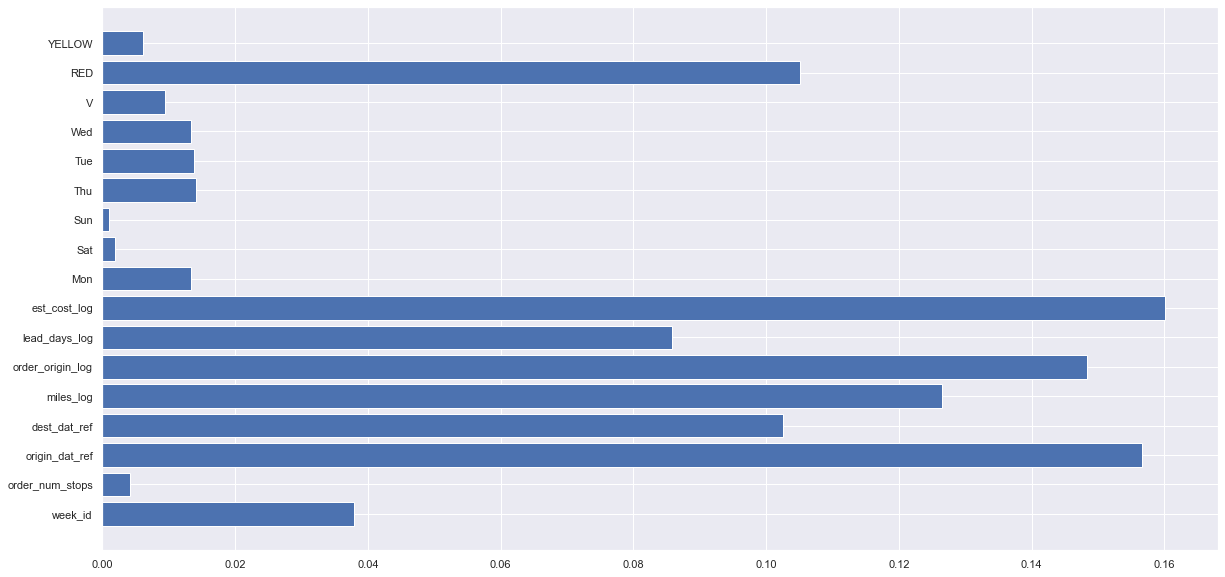

In [1126]:
tree_model.feature_importances_
plt.barh(x_train.columns, tree_model.feature_importances_)

*Develop a visual representation of the decision_tree, noting the most important features*

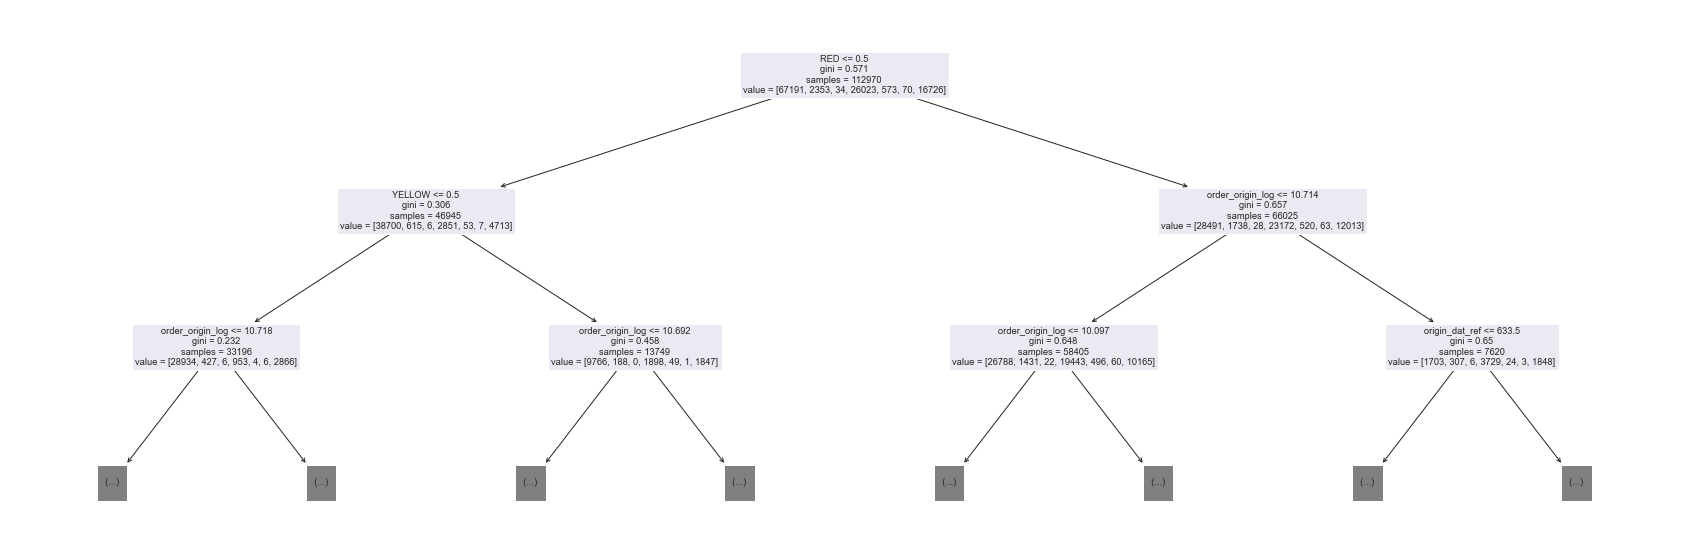

In [1127]:
plt.figure(figsize=(30,10))
tree.plot_tree(tree_model, max_depth = 2, feature_names = x_train.columns)
plt.show()

*Findings of decision tree model*

* My decision tree model is about 67% accurate and has a much greater level of precision that the Logistic Regression model
* The most important features in this model appear to be: est_cost_log, order_origin_log, origin_dat_ref, and miles_log. However, the color, Red/Yellow are 

### Third Model: Random Forest Classifier

*Fit a Random Forest Model using default classifiers and evaluate its accuracy*

In [1128]:
rand_forest = RandomForestClassifier()
rand_forest.fit(x_train, y_train)
rand_forest_predict = rand_forest.predict(x_test)
rand_forest.score(x_test, y_test)

0.7732408038498875

*Test if there is a better random forest model leveraging grid search capabilities vs the default*

In [1129]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [6, 10, 20, 30]
}
gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = -1), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=10)
gridsearch.fit(x_train, y_train)
pd.DataFrame(gridsearch.cv_results_).sort_values( \
                                         by='rank_test_score')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START max_depth=6, n_estimators=10...............................
[CV 1/3; 1/12] END max_depth=6, n_estimators=10;, score=(train=0.618, test=0.617) total time=   1.0s
[CV 2/3; 1/12] START max_depth=6, n_estimators=10...............................
[CV 2/3; 1/12] END max_depth=6, n_estimators=10;, score=(train=0.620, test=0.618) total time=   0.5s
[CV 3/3; 1/12] START max_depth=6, n_estimators=10...............................
[CV 3/3; 1/12] END max_depth=6, n_estimators=10;, score=(train=0.622, test=0.620) total time=   0.5s
[CV 1/3; 2/12] START max_depth=6, n_estimators=20...............................
[CV 1/3; 2/12] END max_depth=6, n_estimators=20;, score=(train=0.622, test=0.621) total time=   0.6s
[CV 2/3; 2/12] START max_depth=6, n_estimators=20...............................
[CV 2/3; 2/12] END max_depth=6, n_estimators=20;, score=(train=0.621, test=0.619) total time=   0.6s
[CV 3/3; 2/12] START max_dept

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
11       1.826613      0.064182         0.163857        0.026379   
10       1.368180      0.167803         0.118962        0.008611   
8        1.609444      0.151287         0.152163        0.012269   
9        1.017386      0.133058         0.098300        0.007206   
7        1.129804      0.078754         0.110921        0.011190   
6        0.678401      0.008215         0.083878        0.001534   
4        0.680446      0.004032         0.086496        0.004684   
5        0.840179      0.005468         0.092164        0.000523   
3        0.514612      0.051674         0.073113        0.001204   
1        0.545177      0.010155         0.077747        0.001816   
2        0.660732      0.020330         0.087895        0.000899   
0        0.590841      0.233765         0.076778        0.002484   

   param_max_depth param_n_estimators                                 params  \
11              30                 30  {'max_depth': 30, 'n_estimators': 30}   
10              30                 20  {'max_depth': 30, 'n_estimators': 20}   
8               20                 30  {'max_depth': 20, 'n_estimators': 30}   
9               30                 10  {'max_depth': 30, 'n_estimators': 10}   
7               20                 20  {'max_depth': 20, 'n_estimators': 20}   
6               20                 10  {'max_depth': 20, 'n_estimators': 10}   
4               10                 20  {'max_depth': 10, 'n_estimators': 20}   
5               10                 30  {'max_depth': 10, 'n_estimators': 30}   
3               10                 10  {'max_depth': 10, 'n_estimators': 10}   
1                6                 20   {'max_depth': 6, 'n_estimators': 20}   
2                6                 30   {'max_depth': 6, 'n_estimators': 30}   
0                6                 10   {'max_depth': 6, 'n_estimators': 10}   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
11           0.752981           0.747351           0.747265         0.749199   
10           0.744749           0.745678           0.741422         0.743950   
8            0.738747           0.738986           0.736377         0.738037   
9            0.733781           0.736277           0.730853         0.733637   
7            0.735614           0.733463           0.730322         0.733133   
6            0.727488           0.722150           0.720018         0.723219   
4            0.664259           0.653292           0.657770         0.658440   
5            0.664153           0.654593           0.655248         0.657998   
3            0.657673           0.654009           0.650175         0.653952   
1            0.620575           0.618504           0.617538         0.618872   
2            0.618584           0.616857           0.621070         0.618837   
0            0.617335           0.618159           0.620432         0.618642   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
11        0.002674                1            0.995645            0.995459   
10        0.001827                2            0.992445            0.992843   
8         0.001178                3            0.927343            0.930092   
9         0.002217                4            0.981504            0.980242   
7         0.002173                5            0.917863            0.927144   
6         0.003142                6            0.911476            0.907201   
4         0.004502                7            0.676603            0.669101   
5         0.004360                8            0.676271            0.669247   
3         0.003061                9            0.671146            0.670535   
1         0.001267               10            0.621526            0.621008   
2         0.001729               11            0.618379            0.619003   
0         0.001310               12            0.617649            0.620411   

    split

*Determined there is not a better model vs the default random forest classifier algorithm. Compute statistics on model*

In [1130]:
rand_forest_cv_score = cross_val_score(rand_forest, 
                            x_train, y_train,
                            scoring = 'accuracy',
                            cv = 3,
                            n_jobs = -1,
                            verbose = 1)
print(rand_forest_cv_score)
print("Accuracy:",metrics.accuracy_score(y_test, rand_forest_predict))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[0.75799984 0.7575484  0.75347886]
Accuracy: 0.7732408038498875


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.5s finished


In [1131]:
print(classification_report(y_test, rand_forest_predict))

                           precision    recall  f1-score   support

                 Accepted       0.80      0.91      0.85     28932
                Cancelled       0.69      0.30      0.42      1033
                   NoPace       0.71      0.25      0.37        20
                 Rejected       0.72      0.67      0.69     11108
    Waiting On Acceptance       0.76      0.35      0.47       226
Waiting On Recommendation       0.00      0.00      0.00        25
                Withdrawn       0.73      0.46      0.56      7073

                 accuracy                           0.77     48417
                macro avg       0.63      0.42      0.48     48417
             weighted avg       0.77      0.77      0.76     48417



*Compute feature importance*

<BarContainer object of 17 artists>

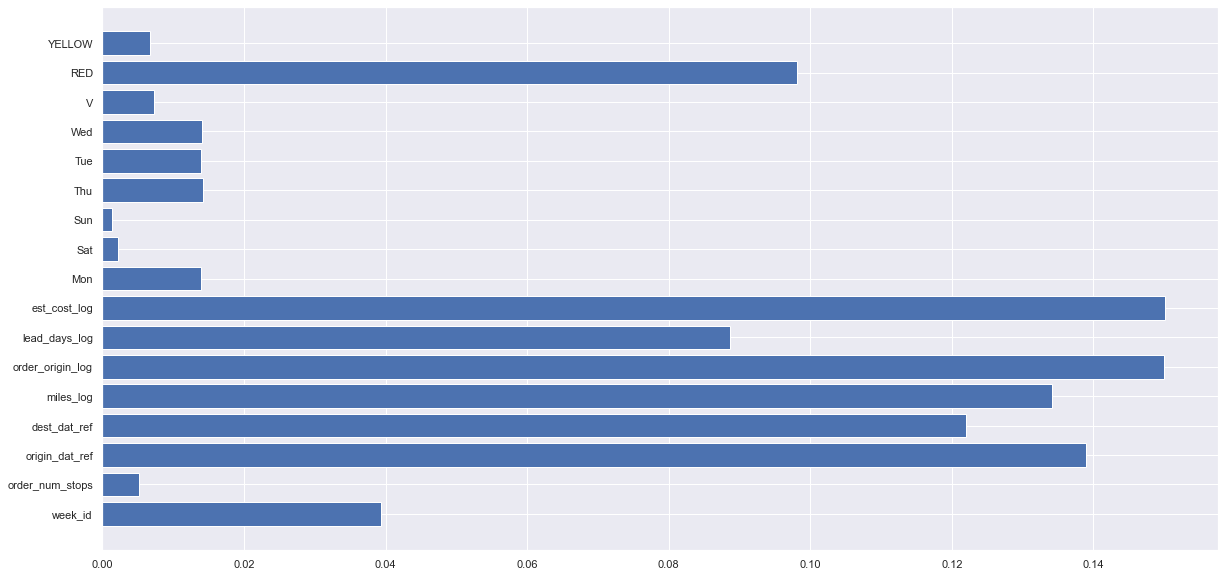

In [1132]:
rand_forest.feature_importances_
plt.barh(x_train.columns, rand_forest.feature_importances_)

*Findings of decision tree model*

* My random forest model is about 77% accurate, 10% more accurate than the decision tree model and 17% more accurate than the logistic regression model.
* The most important features in this model appear to be: order_origin_log, origin_dat_ref, and miles

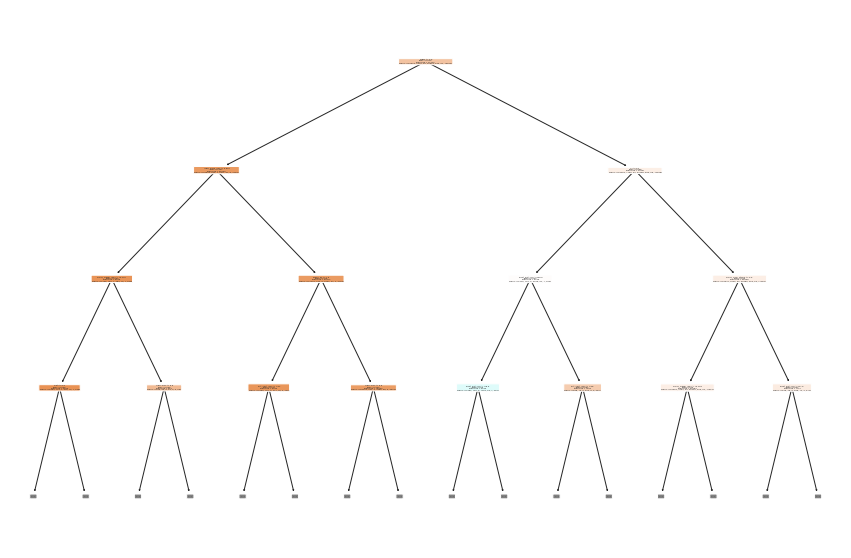

In [1133]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rand_forest.estimators_[0],
          max_depth = 3,
          feature_names=x_test.columns, 
          filled=True, impurity=True, 
          rounded=True)
plt.show()

### Model Summary

**The random forest model appears to be the best model (so far) to predict 'CurrentCondition.' I say this model is the best, because in terms of model precision (True Positives found vs Actual Results), recall (True Positives vs Predicted Results), and F-Scores (accuracy taking into account false negatives/positives) it showed the highest percentage or value closest to 1, showing that this model has an overall higher accuracy of computing 'CurrentCondition'.** 

If I were to further develop any of these models, I would seek to reduce the amount of variables (or features) in the model, such that only the most important features are used to predict 'Current Condition.' I would potentially do this by performing PCA Analysis, or talking with our client partners on variables that would not make sense to be included as part of the prediction.

## Context and Critical Reflection

What questions do you have about this data (list up to two)?  
1. Are any of the variables system-driven, or are they all manually entered? For example, with color, is there something defining color or is it subjective? Does CH Robinson have a portfolio of 'color' that makes it reasonable to be a good predictor?
2. How is 'lead_days' populated? Is it reasonable to have +/- XX lead days?

What steps would you take to address this gap in understanding if you were an employee?
If I were assigned this project, I would work with our partners to further understand the process beginning with the person filling out the request form to the assignment of CurrentCondition. I would ask them if any of the variables are auto-populated based upon other values, and the expectations of valid values in the variables seen in the dataset. I would work with our partners to determine where some of the data might just be 'bad' and should be treated as an anomaly and thrown out of the model prediction, and/or which data is skewed, but is expected to be that way. Their answers could then be used to better frame up the best dataset to model against.